In [1]:
from data_preprocess import *
from train_and_test import *
from config_loader import *

跑通model_v1

In [3]:
model_name = 'model_v1'
# 参数
model_config = models_config[model_name]
batch_size, lr, optim_name, epochs, metric, alpha = (
    model_config['batch_size'],
    model_config['lr'],
    model_config['optimizer'],
    model_config['epochs'],
    model_config['metric'],
    model_config.get('alpha', None)
)

In [4]:
set_seed(42)

# 数据
batteries_df = read_and_norm(data_path, rated_capacity, failure_threshold)  
train_df, _, test_df, train_loader, _, test_loader = load_data(batteries_df, test_bat, seq_length, batch_size)

# 模型、优化器
model = get_model(model_config, device)
optimizer = get_optimizer(optim_name, model, lr, alpha)
criterion = nn.MSELoss()

# 训练
model_save_path = 'saved_models/demo_model_v1.pth'

best_metric = float('inf')
for epoch in range(epochs):
    train_loss = train_epoch(model_config, model, train_loader, device, optimizer, criterion)
    test_loss = test_epoch(model_config, model, test_loader, device, criterion)

    # 在训练集上预测, 并计算评价指标(SP=0)
    sp = 0.0
    train_bats = train_df['battery'].unique()
    train_re_list, train_rmse_list, train_mae_list = [], [], []
    for bat in train_bats:
        bat_df = train_df[train_df['battery'] == bat]
        train_seq = bat_df['capacity'].to_numpy()
        train_pred_seq = predict(model_config, model, sp, train_seq, seq_length, failure_threshold, device)
        train_re, train_rmse, train_mae = cal_metrics(train_seq, train_pred_seq, sp, seq_length, failure_threshold)
        train_re_list.append(train_re)
        train_rmse_list.append(train_rmse)
        train_mae_list.append(train_mae)
    mean_train_re = np.mean(train_re_list)
    mean_train_rmse = np.mean(train_rmse_list)
    mean_train_mae = np.mean(train_mae_list)

    # 在测试集上预测, 并计算评价指标(SP=0)
    test_seq = test_df['capacity'].to_numpy()
    test_pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
    test_re, test_rmse, test_mae = cal_metrics(test_seq, test_pred_seq, sp, seq_length, failure_threshold)

    print(
        f"Epoch [{epoch+1}/{epochs}], "
        f"Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}, "
        f"Train RE: {mean_train_re:.3f}, Train RMSE: {mean_train_rmse:.4f}, Train MAE: {mean_train_mae:.4f}, "
        f"Test RE: {test_re:.3f}, Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}"
    )    

    # 保存模型
    metric = mean_train_re
    if metric < best_metric:
        best_metric = metric
        torch.save(model.state_dict(), model_save_path)
        print("New best model saved ...")

/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/200], Train Loss: 0.02134438, Test Loss: 0.00443354, Train RE: 1.000, Train RMSE: 0.1108, Train MAE: 0.0963, Test RE: 1.000, Test RMSE: 0.1121, Test MAE: 0.0991
New best model saved ...
Epoch [2/200], Train Loss: 0.00480671, Test Loss: 0.00294491, Train RE: 1.000, Train RMSE: 0.1290, Train MAE: 0.1159, Test RE: 1.000, Test RMSE: 0.1303, Test MAE: 0.1182
Epoch [3/200], Train Loss: 0.00307970, Test Loss: 0.00193676, Train RE: 1.000, Train RMSE: 0.1279, Train MAE: 0.1147, Test RE: 1.000, Test RMSE: 0.1292, Test MAE: 0.1171
Epoch [4/200], Train Loss: 0.00229138, Test Loss: 0.00067062, Train RE: 1.000, Train RMSE: 0.0775, Train MAE: 0.0608, Test RE: 1.000, Test RMSE: 0.0776, Test MAE: 0.0627
Epoch [5/200], Train Loss: 0.00201099, Test Loss: 0.00080456, Train RE: 1.000, Train RMSE: 0.0965, Train MAE: 0.0815, Test RE: 1.000, Test RMSE: 0.0971, Test MAE: 0.0833
Epoch [6/200], Train Loss: 0.00164236, Test Loss: 0.00060593, Train RE: 1.000, Train RMSE: 0.0732, Train MAE: 0.0560, Test RE

KeyboardInterrupt: 

In [12]:
# 测试
sp = 0.0
model_save_filename = 'test1'
test_seq = test_df['capacity'].to_numpy()

# 加载模型
model_config = models_config[model_name]
model_path = os.path.join(model_save_dir, model_save_filename + '.pth')
model = get_model(model_config, device)
model.load_state_dict(torch.load(model_path, map_location=device))

# 预测
pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
re, rmse, mae = cal_metrics(test_seq, pred_seq, sp, seq_length, failure_threshold)
print(f"Test RE: {re:.3f}, Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}")

/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/var/folders/6x/w_phznyd4830j7jb8y12rhrc0000gn/T/ipykernel_46872/1585478525.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

Test RE: 0.309, Test RMSE: 0.2021, Test MAE: 0.1511


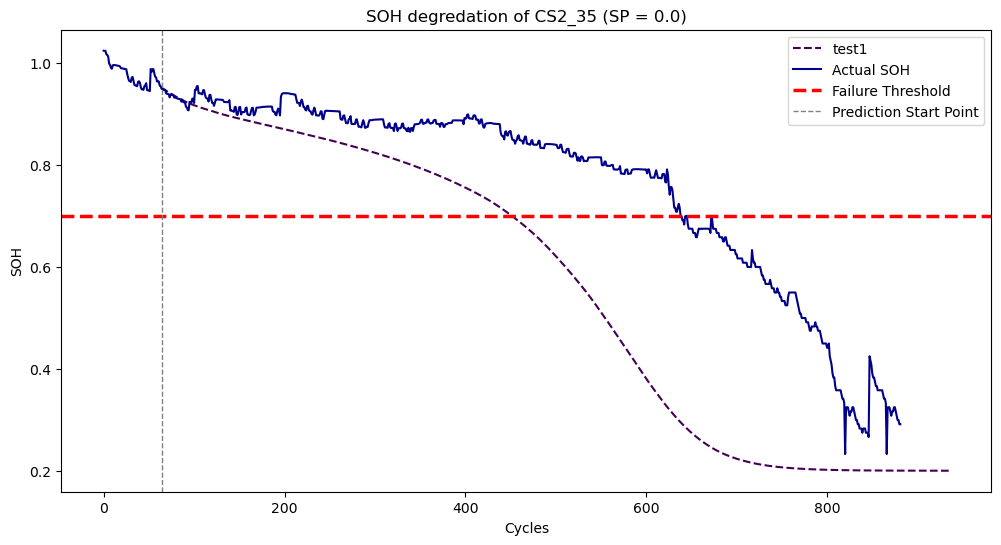

In [11]:
# plot
pred_seqs = {model_save_filename: pred_seq}
plot(test_seq, pred_seqs, sp, failure_threshold, seq_length, test_bat)